In [1]:
import torch
import time
import gc
import math
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import pickle

from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim

import sys
sys.path.append('../code')
from python.commons import full_inference_e2e, inc_inference_e2e, adaptive_drilldown, generate_heatmap
from python.imagenet_classes import class_names
from python.vgg16 import VGG16

image_file_path = "../code/python/dog_resized.jpg"
interested_logit_index = 208

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [27]:
patch_size = 32
stride = 32
gpu = True

In [28]:
if gpu:
    torch.cuda.synchronize()

prev_time = time.time()
x = full_inference_e2e(VGG16, image_file_path, patch_size, stride, interested_logit_index, batch_size=16, gpu=gpu)

if gpu:
    torch.cuda.synchronize()

full_inference_time = time.time() - prev_time
print("Full Inference Time: " + str(full_inference_time))

Full Inference Time: 1.26198983192


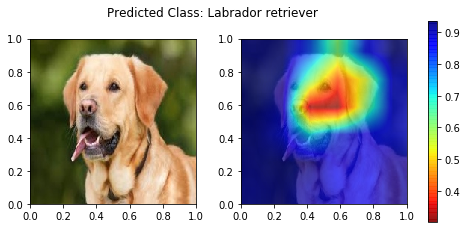

In [29]:
orig_hm = generate_heatmap(image_file_path, x, show=True, label=class_names[interested_logit_index])

output = open('temp', 'w')
pickle.dump(orig_hm, output)

In [30]:
gc.collect()
torch.cuda.empty_cache()

In [31]:
def inc_inference(beta, patch_size=4, stride=1, adaptive=False):
    if gpu:
        torch.cuda.synchronize()
    
    if not adaptive:
        x = inc_inference_e2e(VGG16, image_file_path, patch_size, stride, interested_logit_index,
                                  batch_size=16, beta=beta, gpu=gpu, version='v2')
    else:
        x = adaptive_drilldown(VGG16, image_file_path, patch_size, stride, interested_logit_index,
                                    batch_size=16, beta=beta, percentile=20)
    if gpu:
        torch.cuda.synchronize()

    return x

### Patch growth thresholding

BETA: 1.0 Inference Time: 1.32563710213


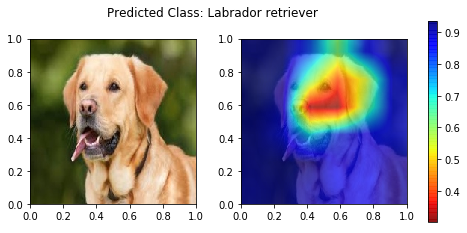

BETA: 0.7 Inference Time: 1.30097413063


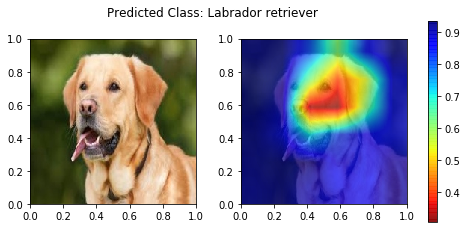

BETA: 0.5 Inference Time: 1.30674791336


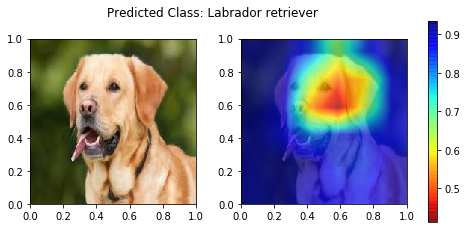

BETA: 0.4 Inference Time: 1.31681799889


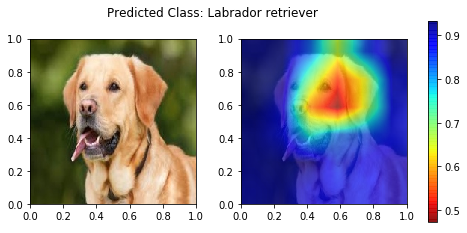

BETA: 0.35 Inference Time: 1.33247089386


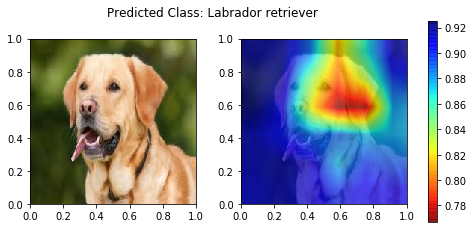

BETA: 0.3 Inference Time: 1.29370999336


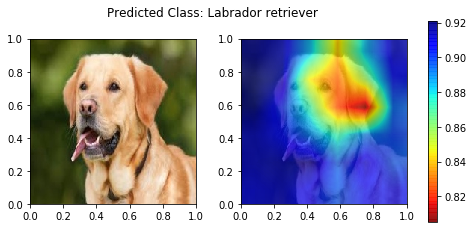

BETA: 0.25 Inference Time: 1.31400513649


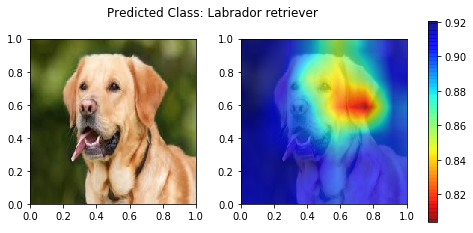

BETA: 0.2 Inference Time: 1.26622414589


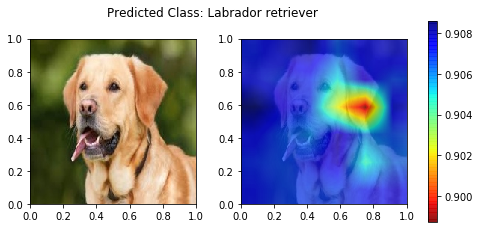

In [32]:
orig_hm = pickle.load(open('temp', 'r'))

times = []
score = []

for beta in [1.0, 0.7, 0.5, 0.4, 0.35, 0.3, 0.25, 0.2]:
    prev_time = time.time()
    x = inc_inference(beta, patch_size=patch_size, stride=stride)
    inc_inference_time = time.time()-prev_time
    times.append(inc_inference_time)
    
    label = "BETA: " + str(beta) +" Inference Time: " + str(inc_inference_time)
    print(label)
    hm = generate_heatmap(image_file_path, x, show=True, label=class_names[interested_logit_index])
    
    if hm.shape[0] < 7:
        win_size=3
    else:
        win_size=None
        
    score.append(ssim(orig_hm, hm, data_range=255, multichannel=True, win_size=win_size))

Text(0,0.5,'SSIM')

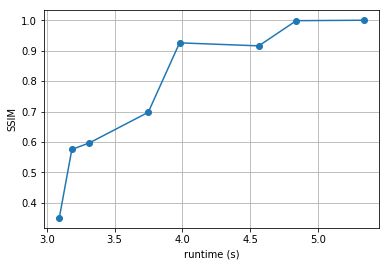

In [24]:
plt.plot(times, score, marker='o')
plt.grid()
plt.xlabel('runtime (s)')
plt.ylabel('SSIM')

In [ ]:
orig_hm = pickle.load(open('temp', 'r'))

times = []
score = []

for beta in [1.0, 0.7, 0.5, 0.4, 0.35, 0.3, 0.25, 0.2]:
    prev_time = time.time()
    x = inc_inference(beta, patch_size=patch_size, stride=stride, adaptive=True)
    inc_inference_time = time.time()-prev_time
    times.append(inc_inference_time)
    
    label = "BETA: " + str(beta) +" Inference Time: " + str(inc_inference_time)
    print(label)
    hm = generate_heatmap(image_file_path, x, show=True, label=class_names[interested_logit_index])
    score.append(ssim(orig_hm, hm, data_range=255, multichannel=True))

In [ ]:
plt.plot(times, score, marker='o')
plt.grid()
plt.xlabel('runtime (s)')
plt.ylabel('SSIM')